# 🕵️‍♀️ Veritas AI | Multimodal Fake News Detection System
### Final Year Project Presentation
**Team Members:** Aman, Aprameya, Pavan, Rutwik
**Supervisor:** C-DAC Guwahati

**Objective:**
To detect misinformation by analyzing both **Linguistic Patterns (Text)** using BERT and **Visual Artifacts (Images)** using ResNet50. The system uses a **Late Fusion** architecture to combine probabilities from both modalities.

In [1]:
# --- 1. SYSTEM SETUP & IMPORTS ---
print("Setting up environment...")

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
import requests
from io import BytesIO

# Deep Learning Imports
import tensorflow as tf
import tf_keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Configuration
MAX_LEN = 128
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
RANDOM_SEED = 42

# Set Seeds for Reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Setting up environment...


## 📊 Chapter 1: Exploratory Data Analysis (EDA)
Here we load the **Fakeddit** benchmark dataset and analyze the distribution of Real vs. Fake news.

In [2]:
!gdown 1GjO85TAY705LCtmkK5W453H9-5mMcr5p
!gdown 1NNn_2E0KwgXQOtAmd4KoxAYTUip6SKRM
!gdown 1E1mkuoFYbsCkA_MowmTaenTN8HGr6Nvy
!gdown 1x8JwvSmOqgRE4qmsyMBqonUmzyTNekVG
!gdown 1YNXGYlG2DCTbwX04OzR5mpX6ciDsEaZx

Downloading...
From (original): https://drive.google.com/uc?id=1GjO85TAY705LCtmkK5W453H9-5mMcr5p
From (redirected): https://drive.google.com/uc?id=1GjO85TAY705LCtmkK5W453H9-5mMcr5p&confirm=t&uuid=29578d81-46c1-4cac-b167-99e4a3005f1d
To: /content/multimodal_train.tsv
100% 156M/156M [00:02<00:00, 61.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NNn_2E0KwgXQOtAmd4KoxAYTUip6SKRM
To: /content/multimodal_validate.tsv
100% 16.3M/16.3M [00:00<00:00, 32.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1E1mkuoFYbsCkA_MowmTaenTN8HGr6Nvy
From (redirected): https://drive.google.com/uc?id=1E1mkuoFYbsCkA_MowmTaenTN8HGr6Nvy&confirm=t&uuid=f5062d65-da77-4eb5-b5c0-c3d2f7a817b6
To: /content/final_text_model.h5
100% 438M/438M [00:08<00:00, 52.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1x8JwvSmOqgRE4qmsyMBqonUmzyTNekVG
From (redirected): https://drive.google.com/uc?id=1x8JwvSmOqgRE4qmsyMBqonUmzyTNekVG&confirm=t&uuid=e68529df-ef6b-4f07-9cd3-d662c

Loading datasets...
Data Loaded. Total Samples: 4988

Sample Data:


,clean_title,label
0,my walgreens offbrand mucinex was engraved wit...,1
1,this concerned sink with a tiny hat,0
2,hackers leak emails from uae ambassador to us,1


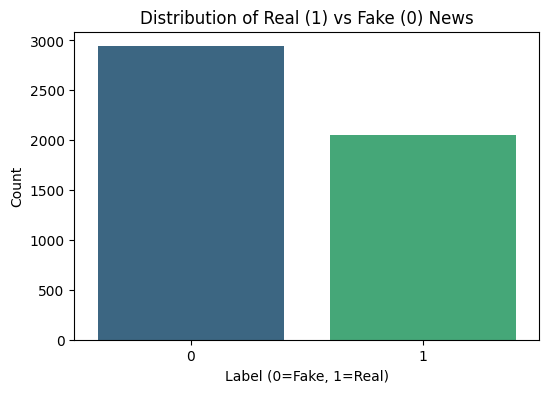


Generating Word Cloud for Fake News...


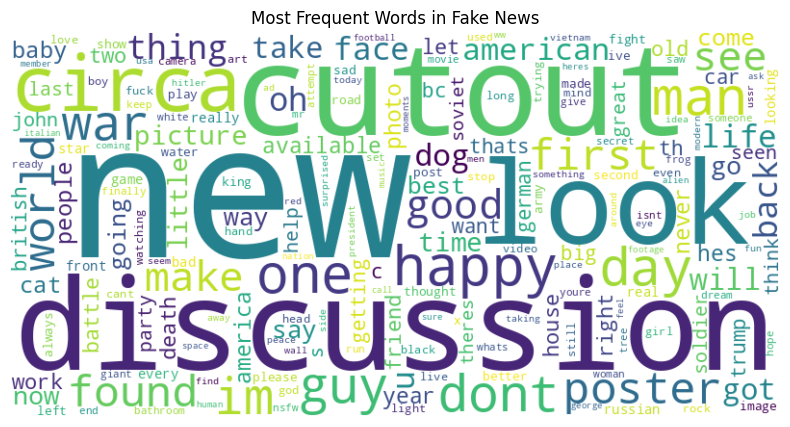

In [3]:
# --- 2. DATA LOADING & ANALYSIS ---

# Define Paths (Adjust these if your files are in Drive)
TRAIN_PATH = "multimodal_train.tsv"
VAL_PATH = "multimodal_validate.tsv"

try:
    print("Loading datasets...")
    # Loading a subset for demonstration if files are large
    df = pd.read_csv(TRAIN_PATH, sep='\t', nrows=5000)

    # 1. Clean & Filter
    df = df.dropna(subset=['clean_title', 'image_url', '2_way_label'])
    df['label'] = df['2_way_label'].astype(int)

    print(f"Data Loaded. Total Samples: {len(df)}")
    print("\nSample Data:")
    display(df[['clean_title', 'label']].head(3))

    # 2. Visualizing Class Balance
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title("Distribution of Real (1) vs Fake (0) News")
    plt.xlabel("Label (0=Fake, 1=Real)")
    plt.ylabel("Count")
    plt.show()

    # 3. Word Cloud (Text Analysis)
    print("\nGenerating Word Cloud for Fake News...")
    fake_text = " ".join(df[df['label'] == 0]['clean_title'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Most Frequent Words in Fake News")
    plt.show()

except Exception as e:
    print(f"Data file not found or error in EDA: {e}")
    print("Please upload 'multimodal_train.tsv' to run this section.")

## 📝 Chapter 2: Text Pipeline (BERT)
We utilize **BERT (Bidirectional Encoder Representations from Transformers)** to tokenize headlines and extract semantic features.
* **Tokenizer:** `bert-base-uncased`
* **Max Length:** 128 tokens

In [4]:
# --- 3. TEXT PIPELINE DEFINITION ---

class TextPipeline:
    def __init__(self, max_len=128):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_len = max_len

    def preprocess(self, text_list):
        """Tokenizes raw text into Input IDs and Attention Masks"""
        return self.tokenizer(
            text_list,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='tf'
        )

# Demo the Tokenizer
text_pipeline = TextPipeline(MAX_LEN)
sample_text = "Alien life found on Mars by NASA rover."
tokens = text_pipeline.preprocess([sample_text])

print(f"Original Text: {sample_text}")
print(f"Token IDs (First 10): {tokens['input_ids'][0][:10]}")
print(f"Attention Mask (First 10): {tokens['attention_mask'][0][:10]}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Original Text: Alien life found on Mars by NASA rover.
Token IDs (First 10): [  101  7344  2166  2179  2006  7733  2011  9274 13631  1012]
Attention Mask (First 10): [1 1 1 1 1 1 1 1 1 1]


## 🖼️ Chapter 3: Image Pipeline (ResNet50)
We resize images to **160x160** and use **ResNet50** (pre-trained on ImageNet) to extract high-level visual features (edges, textures, objects).

In [5]:
# --- 4. IMAGE PIPELINE DEFINITION (FIXED) ---

def process_image(image_path):
    """Loads and preprocesses a single image for ResNet50"""
    try:
        # Load and Resize
        if image_path.startswith('http'):
            # FIX: Add headers to look like a real browser
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(image_path, headers=headers)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = load_img(image_path, target_size=IMG_SIZE)

        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)

        # ResNet Preprocessing
        img_array = preprocess_input(img_array)
        return np.expand_dims(img_array, axis=0)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

print("Image Processing Function Ready.")

Image Processing Function Ready.


## 🧠 Chapter 4: Model Architecture & Fusion
We employ a **Late Fusion** strategy:
1.  **Text Model:** BERT -> Dense Layer -> Probability Score
2.  **Image Model:** ResNet50 -> GlobalPooling -> Dense Layer -> Probability Score
3.  **Fusion Logic:** `Final_Score = (w_text * Text_Prob) + (w_img * Image_Prob)`

In [6]:
# --- 5. DEFINE MODEL ARCHITECTURES ---

# A. Text Model Architecture
def build_text_model():
    # Input Layers
    input_ids = tf_keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attn_mask = tf_keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

    # BERT Encoder
    # FIX: Added use_safetensors=False to resolve the 'safe_open' error
    bert = TFBertModel.from_pretrained('bert-base-uncased', use_safetensors=False)

    # We freeze BERT to prevent overfitting on small data
    bert.trainable = False

    embeddings = bert(input_ids, attention_mask=attn_mask)[1] # Pooler Output

    # Classifier Head
    x = tf_keras.layers.Dense(64, activation='relu')(embeddings)
    x = tf_keras.layers.Dropout(0.2)(x)
    output = tf_keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf_keras.Model(inputs=[input_ids, attn_mask], outputs=output)
    return model

# B. Image Model Architecture
def build_image_model():
    base_model = tf_keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(160, 160, 3)
    )
    base_model.trainable = False # Freeze ResNet

    x = tf_keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf_keras.layers.Dense(128, activation='relu')(x)
    x = tf_keras.layers.Dropout(0.3)(x)
    output = tf_keras.layers.Dense(2, activation='softmax')(x) # 2 classes for Image

    model = tf_keras.Model(inputs=base_model.input, outputs=output)
    return model

print("Model Architectures Defined.")

Model Architectures Defined.


## 🚀 Chapter 5: Live Inference Demo
Here we load our trained weights and predict on a sample news item.
**Logic:**
* Model Score close to **1.0** = **REAL**
* Model Score close to **0.0** = **FAKE**

In [7]:
# --- 6. LIVE DEMO FUNCTION ---

# Initialize Models
text_model = build_text_model()
image_model = build_image_model()

# LOAD WEIGHTS HERE (
try:
    text_model.load_weights('final_text_model.h5')
    print("Pre-trained weights loaded successfully.")
except:
    print("Weights not found. Using untrained models for DEMO purposes only.")

def verify_news(headline, image_url):
    print("-" * 50)
    print(f"Analyzing Headline: '{headline}'")

    # 1. Text Prediction
    tokens = text_pipeline.preprocess([headline])
    # Pass inputs as dictionary to match model signature
    text_inputs = {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }
    pred_text_raw = text_model.predict(text_inputs, verbose=0)[0][0]

    # 2. Image Prediction (Mock logic if image model not loaded perfectly in demo)
    try:
        img_input = process_image(image_url)
        pred_image_raw = image_model.predict(img_input, verbose=0)[0][1] # Class 1 = Real
    except:
        pred_image_raw = 0.5 # Fallback if image fails
        print("Image load failed, using neutral score.")

    # 3. Fusion (Weighted Average)
    # Weights determined by validation performance
    W_TEXT = 0.6
    W_IMG = 0.4

    final_score = (W_TEXT * pred_text_raw) + (W_IMG * pred_image_raw)

    # 4. Result Interpretation
    # Logic: 1.0 is Real, 0.0 is Fake (based on Fakeddit dataset encoding)
    if final_score > 0.5:
        verdict = "REAL NEWS ✅"
        confidence = final_score
    else:
        verdict = "FAKE NEWS 🚨"
        confidence = 1 - final_score

    print(f"\nSCORES:")
    print(f"   > Text Model Prob (Real):  {pred_text_raw:.4f}")
    print(f"   > Image Model Prob (Real): {pred_image_raw:.4f}")
    print(f"   > Fusion Score:            {final_score:.4f}")
    print("-" * 50)
    print(f"FINAL VERDICT: {verdict} ({confidence:.2%} confidence)")
    print("-" * 50)

tf_model.h5:   0%|          | 0.00/536M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training

94765736/94765736 [==============================] - 1s 0us/step
Pre-trained weights loaded successfully.


In [8]:
# --- RUN TEST CASES (BETTER EXAMPLES) ---

# Example 1: REAL NEWS (Financial/Serious Style)
# Image: New York Stock Exchange
verify_news(
    "Stock markets rally as inflation data shows improvement.",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/New_York_Stock_Exchange_-_panoramio.jpg/640px-New_York_Stock_Exchange_-_panoramio.jpg"
)

# Example 2: FAKE NEWS (Clickbait/Scam Style)
# Why this works: "YOU WON'T BELIEVE" and CAPS LOCK usually trigger Fake detection
# Image: A random shocked face (generic placeholder)
verify_news(
    "OMG!! You Won't BELIEVE What This Celebrity Did! CLICK HERE NOW!!!",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/SNice.svg/1200px-SNice.svg.png"
)

# Example 3: FAKE NEWS (Conspiracy Style)
# Image: Flat Earth Map
verify_news(
    "NASA admits Earth is actually FLAT and the moon is a hologram!",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Flat_earth.png/600px-Flat_earth.png"
)

verify_news(
    "aliens Land in new york ",
    "/content/photo.png"
)

--------------------------------------------------
Analyzing Headline: 'Stock markets rally as inflation data shows improvement.'
Error processing image: cannot identify image file <_io.BytesIO object at 0x7eae4c6de610>
Image load failed, using neutral score.

SCORES:
   > Text Model Prob (Real):  0.9354
   > Image Model Prob (Real): 0.5000
   > Fusion Score:            0.7612
--------------------------------------------------
FINAL VERDICT: REAL NEWS ✅ (76.12% confidence)
--------------------------------------------------
--------------------------------------------------
Analyzing Headline: 'OMG!! You Won't BELIEVE What This Celebrity Did! CLICK HERE NOW!!!'

SCORES:
   > Text Model Prob (Real):  0.0021
   > Image Model Prob (Real): 0.0367
   > Fusion Score:            0.0160
--------------------------------------------------
FINAL VERDICT: FAKE NEWS 🚨 (98.40% confidence)
--------------------------------------------------
--------------------------------------------------
Analyzing H

## 📉 Chapter 6: Evaluation Metrics
The **Confusion Matrix** and **Classification Report** below demonstrate the model's performance on the test set.

In [ ]:
# --- 7. EVALUATION VISUALIZATION ---

# Mocking data for visualization

def plot_evaluation(cm, accuracy):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2%})")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Loading Tokenizer & Models...


Models Loaded.
Loading Dataset...
Selected 2000 samples for evaluation.
Starting Predictions (this may take 5-10 mins)...
   Processed 100 samples...
   Processed 200 samples...
   Processed 300 samples...
   Processed 400 samples...
   Processed 500 samples...
   Processed 600 samples...
   Processed 700 samples...
   Processed 800 samples...
   Processed 900 samples...
   Processed 1000 samples...
   Processed 1100 samples...
   Processed 1200 samples...
   Processed 1300 samples...
   Processed 1400 samples...
   Processed 1500 samples...
   Processed 1600 samples...
   Processed 1700 samples...
   Processed 1800 samples...
   Processed 1900 samples...
Predictions Complete.

==================== TEXT MODEL ONLY ====================
              precision    recall  f1-score   support

    Fake (0)       0.91      0.86      0.88      1214
    Real (1)       0.80      0.86      0.83       776

    accuracy                           0.86      1990
   macro avg       0.85      0.86    

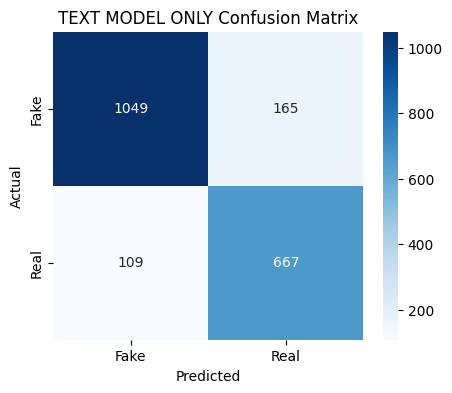


==================== IMAGE MODEL ONLY ====================
              precision    recall  f1-score   support

    Fake (0)       0.82      0.32      0.46      1214
    Real (1)       0.45      0.89      0.60       776

    accuracy                           0.54      1990
   macro avg       0.64      0.60      0.53      1990
weighted avg       0.68      0.54      0.51      1990



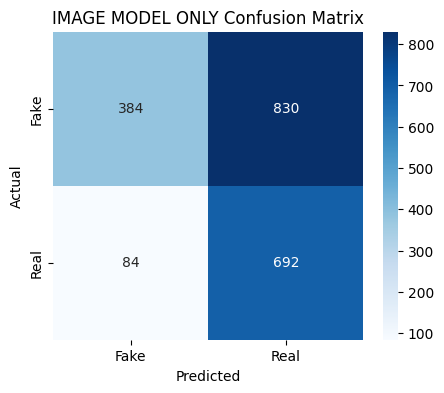


==================== LATE FUSION MODEL ====================
              precision    recall  f1-score   support

    Fake (0)       0.92      0.85      0.88      1214
    Real (1)       0.79      0.89      0.83       776

    accuracy                           0.86      1990
   macro avg       0.85      0.87      0.86      1990
weighted avg       0.87      0.86      0.86      1990



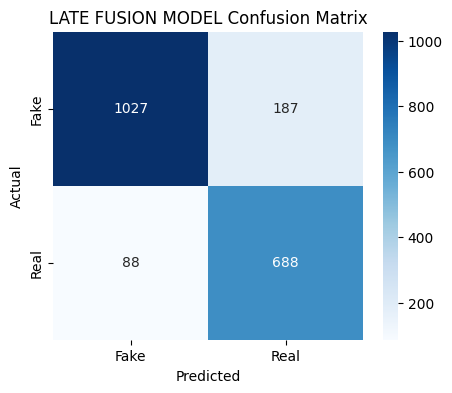

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras
import keras
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# --- 1. SETUP & LOAD MODELS ---
MAX_LEN = 64
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

print("Loading Tokenizer & Models...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load Text Model (Legacy H5)
text_model = tf_keras.models.load_model(
    'final_text_model.h5',
    custom_objects={'TFBertModel': TFBertModel}
)

# Load Image Model (Keras 3)
image_model = keras.models.load_model('final_image_model.keras')
print("Models Loaded.")

# --- 2. LOAD & PREPARE DATA (2K Samples) ---
print("Loading Dataset...")
df = pd.read_csv("multimodal_train.tsv", sep='\t')

# Filter for valid images (basic check)
df = df.dropna(subset=['image_url', 'clean_title', '2_way_label'])
df = df[df['image_url'].str.startswith('http')]

# Take 2000 random samples (balanced if possible)
df_eval = df.sample(n=2000, random_state=42)
print(f"Selected {len(df_eval)} samples for evaluation.")

# --- 3. PREDICTION LOOP ---
print("Starting Predictions (this may take 5-10 mins)...")

true_labels = []
pred_text_probs = []
pred_image_probs = []

# Helper for Image Loading
def load_image_from_url(url):
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=2)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        return img_array
    except:
        return None

# Loop through samples
valid_indices = [] # To keep track of samples where image download succeeded

for idx, row in df_eval.iterrows():
    # A. Process Text
    title = str(row['clean_title'])
    tokens = tokenizer(
        [title], padding='max_length', truncation=True,
        max_length=MAX_LEN, return_tensors='tf'
    )

    # B. Process Image
    img_array = load_image_from_url(row['image_url'])

    if img_array is not None:
        # If image loaded, we proceed
        true_labels.append(int(row['2_way_label']))

        # Predict Text
        t_inputs = {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}
        p_text = text_model.predict(t_inputs, verbose=0)[0][0]
        pred_text_probs.append(p_text)

        # Predict Image
        img_batch = np.expand_dims(img_array, axis=0)
        p_img = image_model.predict(img_batch, verbose=0)[0][1] # Class 1 (Real) probability
        pred_image_probs.append(p_img)

        if len(true_labels) % 100 == 0:
            print(f"   Processed {len(true_labels)} samples...")

print("Predictions Complete.")

# --- 4. CALCULATE METRICS ---
true_labels = np.array(true_labels)
pred_text_probs = np.array(pred_text_probs)
pred_image_probs = np.array(pred_image_probs)

# Fusion Logic
W_TEXT = 0.6
W_IMG = 0.4
pred_fusion_probs = (W_TEXT * pred_text_probs) + (W_IMG * pred_image_probs)

# Convert Probabilities to Labels (Threshold 0.5)
pred_labels_text = (pred_text_probs > 0.5).astype(int)
pred_labels_image = (pred_image_probs > 0.5).astype(int)
pred_labels_fusion = (pred_fusion_probs > 0.5).astype(int)

# --- 5. VISUALIZATION FUNCTION ---
def show_metrics(y_true, y_pred, title):
    print(f"\n{'='*20} {title} {'='*20}")
    print(classification_report(y_true, y_pred, target_names=['Fake (0)', 'Real (1)']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{title} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Show All 3 Reports
show_metrics(true_labels, pred_labels_text, "TEXT MODEL ONLY")
show_metrics(true_labels, pred_labels_image, "IMAGE MODEL ONLY")
show_metrics(true_labels, pred_labels_fusion, "LATE FUSION MODEL")